In [1]:
import os
import pandas as pd
data = pd.read_csv('data/data.csv', header=None)
data

,0,1,2,3
0,300000,«Наёмники блокчейна» — как ими становятся?,"['Dash', 'блокчейн', 'криптовалюта', 'управлен...",data/habr/post__300000.txt
1,300002,Динамичность должна быть безопасной,"['стартапы', 'программы', 'разработка программ...",data/habr/post__300002.txt
2,300004,Издательства выступают против блокировщика рек...,"['mozilla', 'Brave', 'блокировщики рекламы', '...",data/habr/post__300004.txt
3,300006,"Выход из зоны комфорта, как новая бизнес-модель","['бизнес-модель', 'it', 'стартап', 'интернет',...",data/habr/post__300006.txt
4,300008,«Уберизация» поможет российскому рынку рекрути...,"['mail.ru group', 'headhunter', 'российский ры...",data/habr/post__300008.txt
...,...,...,...,...
177,300390,Капитализация Kamcord превысила $100 млн после...,"['Time Warner', 'time warner cable', 'kamcord'...",data/habr/post__300390.txt
178,300392,Конференция ISDEF-2016 в Казани: почему это бы...,"['isdef', 'конференция', 'ит-бизнес', '\n ...",data/habr/post__300392.txt
179,300394,AVO и другие альтернативы роумингу,"['роуминг', 'voip', 'конкуренты', 'стартапы', ...",data/habr/post__300394.txt
180,300396,Шпаргалка в офис: ключевые метрики для развити...,"['метрики', 'развитие бизнеса', '\n ...",data/habr/post__300396.txt


In [2]:
from utils import read_file
publications = [path for path in data[1]]
joined_publications = ' '.join(publications)

In [3]:
import matplotlib.pyplot as plt
from wordcloud import  WordCloud

def plot_wordcloud(text, title=''):
    plt.figure(figsize=(8,10))
    wc = WordCloud(max_words=1000, random_state=1).generate(text)
    plt.title(title)
    plt.imshow(wc)
    plt.show()

In [4]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alexa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Предобработки
- Удаление пробельных символов
- Удаление спец символов
- Токенезация
- Удаление стандартного списка стоп-слов
- Удаление чисел
- Приведение к нижнему регистру

In [5]:
import re
from utils import compose
def remove_stopwords(stop_words):
    return lambda tokens: (token for token in tokens if token not in stop_words)
def tolower(tokens):
    return (token.lower() for token in tokens)
def tokenize(text):
    return word_tokenize(text, language='russian')   
def remove_numbers(tokens):
    def is_number(string):
        try:
            float(string)
            return True
        except ValueError:
            return False
    return (token for token in tokens if not is_number(token))
def remove_spaces(text):
    return re.sub(r'\s', ' ', text)
def remove_symbols(symbols):
    return lambda text: re.sub(symbols + '+', ' ', text)

## Специальные символы
- Арифметические операции
- Знаки препинания
- Различные скобки
- Слэши
- "Мягкий" дефис: \xad 
- А также $, #, №, @, €, •

In [6]:
special_symbols = r'''[-+\%*;:\'"()[\]^$#№@!.,?/|\\<>{}—«»€–\xad•]'''
stop_words = set(stopwords.words('russian'))
remove_default_stopwords = remove_stopwords(stop_words)
preprocesses = [remove_spaces, remove_symbols(special_symbols), tokenize, remove_default_stopwords, remove_numbers, tolower]

In [7]:
preprocessed_publications = [' '.join(compose(preprocesses)(publication)) for publication in publications]
joined_preprocessed_publications = ' '.join(preprocessed_publications)


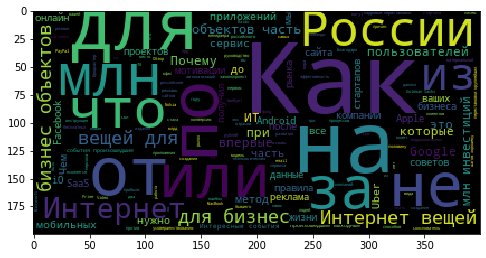

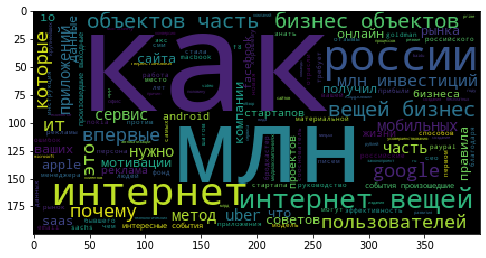

In [8]:
plot_wordcloud(joined_publications)
plot_wordcloud(joined_preprocessed_publications)

## Меры
- Обычная Евклидова
- Нормализованная Евклидова
- Косинусное расстояние

In [9]:
import scipy as sp
def simple_eucl(v1, v2):
    delta = v1 - v2
    return sp.linalg.norm(delta.toarray())
def normal_eucl(v1, v2):
    normal_v1 = v1 / sp.linalg.norm(v1.toarray())
    normal_v2 = v2 / sp.linalg.norm(v2.toarray())
    delta = normal_v1 - normal_v2
    return sp.linalg.norm(delta.toarray())
def cosine(v1, v2):
    return sp.spatial.distance.cosine(v1.toarray(), v2.toarray())

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
def make_vectorizer(src, min_df=1, max_df=1.5, *, verbose=False, request=None):
    vectorizer = CountVectorizer(min_df=min_df, max_df=max_df)
    x_train = vectorizer.fit_transform(src)
    if verbose:
        sample_count, feature_count = x_train.shape
        print(f'titles_count={sample_count}, words_count={feature_count}')
    if request:
        return vectorizer, x_train, vectorizer.transform([request])
    return vectorizer, x_train

In [11]:
def get_distances(dist_func, src):
    return sorted(((dist_func(x_train.getrow(idx), request_vec), text, idx) for idx, text in enumerate(src)), key=lambda x: x[0])

In [26]:
def check_results(src, count=1):
    for dist in distances:
        print(f'-----------{dist.__name__}-----------')
        results = get_distances(dist, src)[:count]
        for idx, res in enumerate(results):
            print(f'{idx + 1}. Best publication is {res[2]} with distance = {res[0]} :\n {res[1]}')

In [29]:
request = 'данные'
distances = [simple_eucl, normal_eucl, cosine]

In [30]:
vectorizer, x_train, request_vec = make_vectorizer(publications, verbose=True, request=request)
check_results(publications, 5)

titles_count=182, words_count=1036
-----------simple_eucl-----------
1. Best publication is 17 with distance = 1.7320508075688772 :
 Смартфоны наступают
2. Best publication is 26 with distance = 1.7320508075688772 :
 Правда о путешественниках
3. Best publication is 29 with distance = 2.0 :
 Полномочия менеджера проекта
4. Best publication is 118 with distance = 2.0 :
 6 причин вашей усталости
5. Best publication is 156 with distance = 2.0 :
 Иллюзия больших данных
-----------normal_eucl-----------
1. Best publication is 170 with distance = 1.0514622242382672 :
 Во что превратятся большие данные
2. Best publication is 46 with distance = 1.0878894332937856 :
 Монетизация мобильных игр. Данные исследования Swrve
3. Best publication is 159 with distance = 1.0878894332937856 :
 Персональные данные: новые правила в Европейском Союзе
4. Best publication is 0 with distance = 1.414213562373095 :
 «Наёмники блокчейна» — как ими становятся?
5. Best publication is 3 with distance = 1.4142135623730

In [31]:
vectorizer, x_train, request_vec = make_vectorizer(preprocessed_publications, verbose=True, request=request)
check_results(preprocessed_publications, 5)

titles_count=182, words_count=982
-----------simple_eucl-----------
1. Best publication is 17 with distance = 1.7320508075688772 :
 смартфоны наступают
2. Best publication is 26 with distance = 1.7320508075688772 :
 правда путешественниках
3. Best publication is 170 with distance = 1.7320508075688772 :
 во превратятся большие данные
4. Best publication is 1 with distance = 2.0 :
 динамичность должна безопасной
5. Best publication is 24 with distance = 2.0 :
 методика деньги мои
-----------normal_eucl-----------
1. Best publication is 170 with distance = 1.0 :
 во превратятся большие данные
2. Best publication is 46 with distance = 1.0878894332937856 :
 монетизация мобильных игр данные исследования swrve
3. Best publication is 159 with distance = 1.0878894332937856 :
 персональные данные новые правила европейском союзе
4. Best publication is 8 with distance = 1.414213562373095 :
 простых способов сформировать умение понимать эмоции других людей
5. Best publication is 12 with distance = 